In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [2]:
from pyTVDN import TVDNDetect, TVDNRankTuning
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyTVDN.tmpUtils import *
from scipy.signal import lfilter, firls, decimate
%matplotlib inline
plt.style.use('ggplot')

In [3]:
from pprint import pprint
import pickle
from easydict import EasyDict as edict
import warnings
from pyTVDN.TVDNutils import *
from pyTVDN.utils import in_notebook
if in_notebook():
    from tqdm import tqdm_notebook as tqdm
else:
    from tqdm import tqdm

class TVDNDetect1(TVDNDetect):
    def SmoothEst(self):
        if self.nYmat is None:
            self._Preprocess()
        d, n = self.nYmat.shape
        acTime = n / self.paras.freq
        self.ptime = np.linspace(0, acTime, n)
        self.time = np.linspace(0, self.paras.T, n)
        divNum = 100
        if self.smoothType == "bspline":
            self.dXmat = np.zeros((d, n))
            self.Xmat = np.zeros((d, n))
            if n%divNum == 0:
                numLoop = int(n/divNum)
            else:
                numLoop = int(n/divNum) + 1
            for i in range(numLoop):
                if (i+1)*divNum <= n:
                    low = i*divNum
                    up = (i+1)*divNum
                else:
                    low = i*divNum
                    up = n
                self.dXmat[:, low:up], self.Xmat[:, low:up] = GetBsplineEst(self.nYmat[:, low:up], self.time[low:up], 
                                                                            lamb=self.paras.lamb)
        elif self.smoothType == "fourier":
            self.dXmat, self.Xmat = GetFourierEst(self.nYmat, self.time, nbasis=self.paras.nbasis)
            

In [4]:
resDir = Path("../results")
dataDir = Path("../data/MEG-resting-state")

In [5]:
datFil = list(dataDir.glob("*8008*min.mat"))[0]
print(datFil)

MEG = loadmat(datFil)
data = MEG["DK_timecourse"]
data.shape

../data/MEG-resting-state/lcmv_result_8008-101_wo_filtering_min.mat


(68, 35999)

The time course is 60 seconds, so the frequency is 600 Hz

###  Data preprocessing

In [6]:
q = 5
dataN = decimate(data, q=q)
dataN = detrend(dataN)

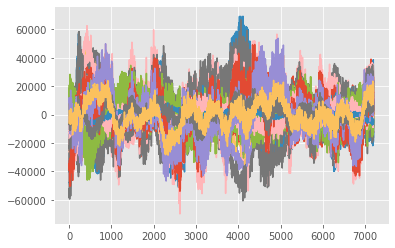

In [7]:
d, n = dataN.shape
for i in range(d):
    plt.plot(dataN[i, :])

### Tuning kappa

In [25]:
paras = edict()
paras.Lmin = 200
paras.wh = 10
paras.MaxM = 20
paras.fct = 0.5
paras.r = 6
paras.freq = 120
paras.lamb = 1e-2
paras.T = 2
paras.is_detrend = False
paras.decimateRate = None
paras.kappa = 2.77
paras.downRate = 20

detObjs = []
for i in range(5):
    dataPart = data[:, i::5]
    detPart = TVDNDetect(Ymat=dataPart, dataType="MEG", 
                         saveDir=None, #"MEGst02", 
                         fName="MEG1",
                         showProgress=True, 
                         MaxM=paras.MaxM,
                         Lmin=paras.Lmin, 
                         lamb=paras.lamb, 
                         kappa=paras.kappa, 
                         freq=paras.freq,
                         r=paras.r,
                         T=paras.T,
                         is_detrend=paras.is_detrend,
                         decimateRate=paras.decimateRate, 
                         downRate=paras.downRate)
    detPart.Screening(wh=paras.wh)
    detPart()
    kappas = np.arange(1, 4, 0.001)
    detPart.TuningKappa(kappas)
    detObjs.append(detPart)

The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG1',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 2.77,
 'lamb': 0.01,
 'nbasis': 10,
 'r': 6}



The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG1',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 2.77,
 'lamb': 0.01,
 'nbasis': 10,
 'r': 6}



The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG1',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 2.77,
 'lamb': 0.01,
 'nbasis': 10,
 'r': 6}



The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG1',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 2.77,
 'lamb': 0.01,
 'nbasis': 10,
 'r': 6}



The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG1',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 2.77,
 'lamb': 0.01,
 'nbasis': 10,
 'r': 6}


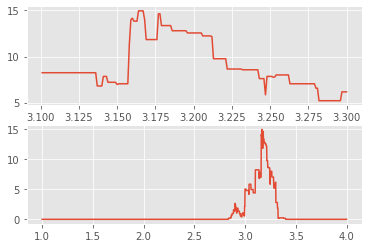

In [44]:
numchgss = []
for i in range(5):
    numchgs = detObjs[i].numchgs
    numchgss.append(numchgs)
    
numchgssArr = np.array(numchgss)
varsAll = np.var(numchgssArr, axis=0)

kpidxs = ((kappas >= 3.1).astype(np.int) + (kappas<=3.3)) == 2
subVarsAll = varsAll[kpidxs]
subKappas = kappas[kpidxs]

plt.subplot(211)
plt.plot(subKappas, subVarsAll)
plt.subplot(212)
plt.plot(kappas, varsAll)

In [45]:
optKaIdx = np.argmin(subVarsAll)
optKappa = subKappas[optKaIdx]
print(optKappa)

3.2819999999997487


## Detection on data with screening and no HPF

In [46]:
paras = edict()
paras.Lmin = 200
paras.wh = 10
paras.MaxM = 20
paras.fct = 0.5
paras.r = 6
paras.freq = 120
paras.lamb = 1e-2
paras.T = 2
paras.is_detrend = False
paras.decimateRate = None
paras.kappa = optKappa
paras.downRate = 20

In [47]:
detRaw = TVDNDetect(Ymat=dataN, dataType="MEG", 
                     saveDir=None, #"MEGst02", 
                     fName="MEG1",
                     showProgress=True, 
                     MaxM=paras.MaxM,
                     Lmin=paras.Lmin, 
                     lamb=paras.lamb, 
                     kappa=paras.kappa, 
                     freq=paras.freq,
                     r=paras.r,
                     T=paras.T,
                     is_detrend=paras.is_detrend,
                     decimateRate=paras.decimateRate, 
                     downRate=paras.downRate)

The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG1',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 3.2819999999997487,
 'lamb': 0.01,
 'nbasis': 10,
 'r': 6}


In [48]:
detRaw.Screening(wh=paras.wh)
detRaw()

Sequences after B-spline

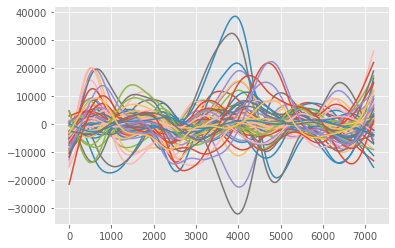

In [49]:
for i in range(detRaw.Xmat.shape[0]):
    plt.plot(detRaw.Xmat[i, :])

+-------------+--------------------------------------+--------------------+------+
| Num of CPTs |            Estiamted CPTs            |        MSE         | Rank |
+-------------+--------------------------------------+--------------------+------+
|      7      | [ 883 2082 3327 3988 4675 5396 6528] | 2.9231668975708764 |  6   |
+-------------+--------------------------------------+--------------------+------+


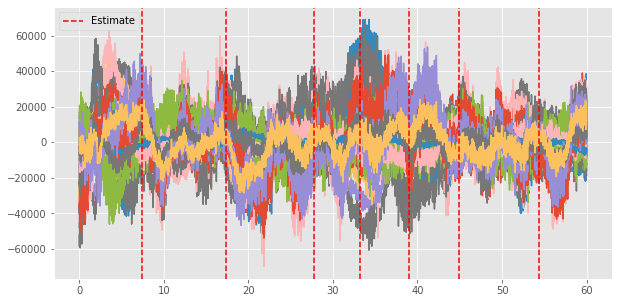

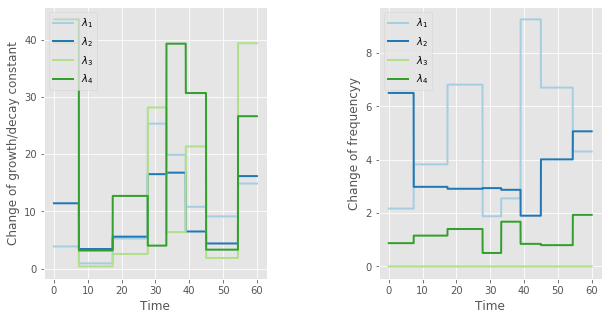

In [50]:
print(detRaw)
detRaw.PlotEcpts()
detRaw.PlotEigenCurve()

In [51]:
np.diff(detRaw.ecpts)

array([1199, 1245,  661,  687,  721, 1132])